In [621]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 #cv2 for image processing
import random
import os
import numpy as np #NumPy for array manipulation
import matplotlib.pyplot as plt #Matplotlib for visualizing the performance of the models
import matplotlib.image as mpimg
%matplotlib inline

import keras #Keras is a library for building neural networks on top of TensorFlow
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.applications import InceptionResNetV2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import layers, models, optimizers

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Haarcascade Facial Recognition

In [622]:
Haar_model = cv2.CascadeClassifier('../input/haarcascade/haarcascade_frontalface_default.xml')

In [623]:
def Haar_boxFaces(path, model):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = Haar_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
    out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    for (x,y,w,h) in faces:
        cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
    return (out_img,faces)

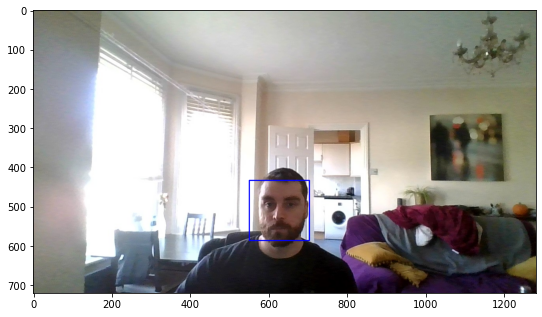

In [624]:
path = '../input/mask-no-mask-images/WIN_20210223_09_15_33_Pro.jpg'
img_BBDaniel = Haar_boxFaces(path, Haar_model)
plt.figure(figsize=(9,9))
plt.imshow(img_BBDaniel[0])

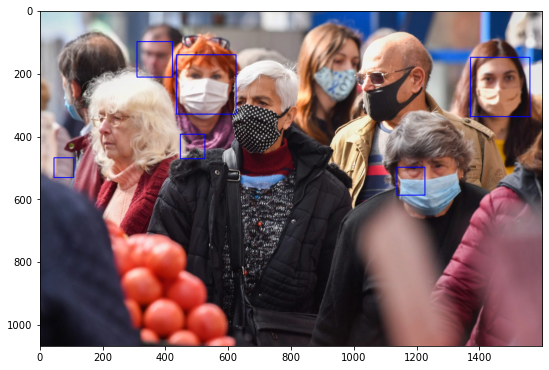

In [587]:
path = '../input/mask-no-mask-images/faces1.jpg'
img_BBDaniel = Haar_boxFaces(path, Haar_model)
plt.figure(figsize=(9,9))
plt.imshow(img_BBDaniel[0])

In [588]:
model = keras.models.load_model('../input/resmasknet/masknet.h5')

In [589]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 57,876,450
Trainable params: 3,539,714
Non-trainable params: 54,336,736
_________________________________________________________________


In [590]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

In [591]:
def ResMaskNet(path, model, faces):
    img = cv2.imread(path)
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(150,150))
        crop = np.reshape(crop,[1,150,150,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[mask_result.argmax()],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[mask_result.argmax()],1)
    plt.figure(figsize=(11,11))
    return plt.imshow(new_img)    

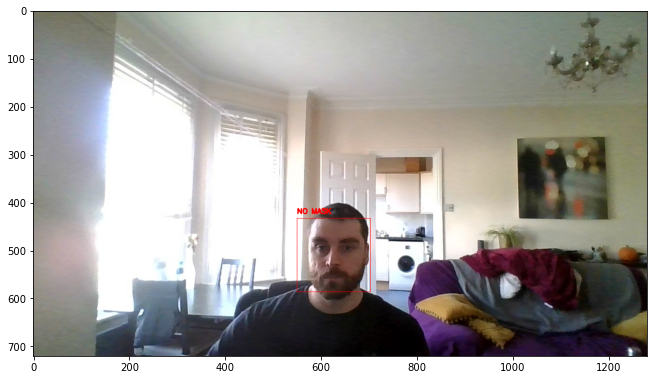

In [592]:
path = '../input/mask-no-mask-images/WIN_20210223_09_15_33_Pro.jpg'
img_bb = Haar_boxFaces(path, Haar_model)
ResMaskNet(path=path,model=model, faces=img_bb[1])

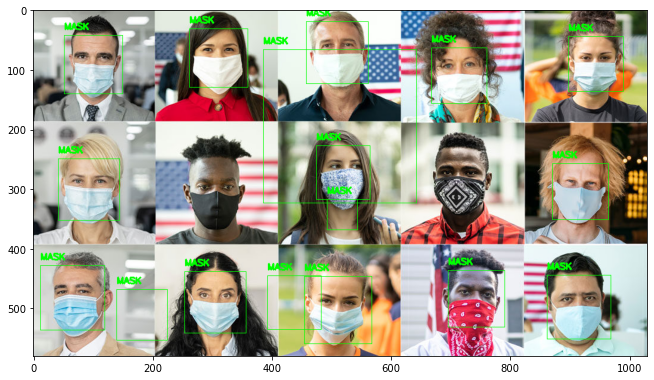

In [593]:
path = '../input/mask-no-mask-images/faces3.jpg'
img_bb = Haar_boxFaces(path, Haar_model)
ResMaskNet(path=path,model=model, faces=img_bb[1])

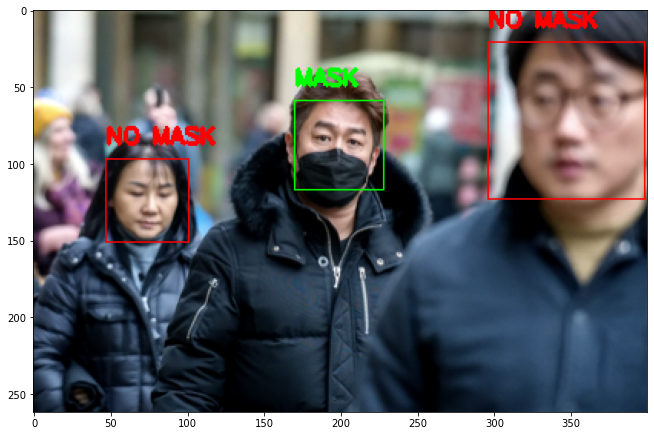

In [594]:
path = '../input/mask-no-mask-images/test_multiple.png'
img_bb = Haar_boxFaces(path, Haar_model)
ResMaskNet(path=path,model=model, faces=img_bb[1])

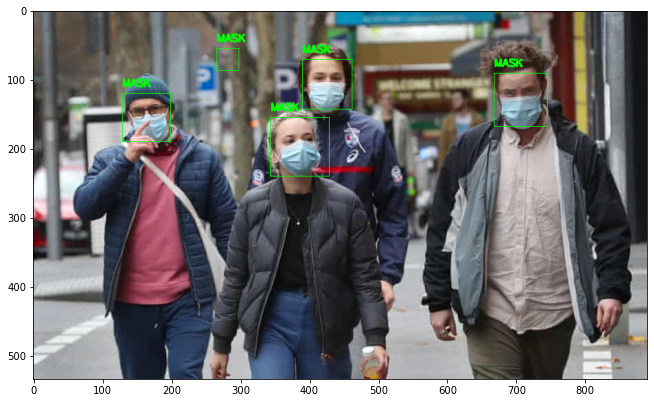

In [595]:
path = '../input/mask-no-mask-images/faces2.jpg'
img_bb = Haar_boxFaces(path, Haar_model)
ResMaskNet(path=path,model=model, faces=img_bb[1])

# Caffe Facial Recognition

In [596]:
architecture = '../input/caffe-face-detector-opencv-pretrained-model/architecture.txt'
weights = '../input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel'

In [597]:
net = cv2.dnn.readNetFromCaffe(architecture, weights)

In [598]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(0,0,255)}

In [599]:
def Caffe_boxFaces(path, model):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    
    blob = cv2.dnn.blobFromImage(
        image=cv2.resize(img, (224, 224)),
        scalefactor=1.0,
        size=(224,224),
        mean=(104.0, 177.0, 123.0),
    )
    
    net.setInput(blob)
    preds = net.forward()
    h, w = img.shape[:2]
    threshold = 0.128
    faces=[]
    
    for i in range(0, preds.shape[2]):
        confidence = preds[0, 0, i, 2]
        if confidence > threshold:
            box = preds[0, 0, i, 3:7] * np.array([w, h, w, h])
            startX, startY, endX, endY = box.astype('int')
            text = '{:.2f}%'.format(confidence * 100)
            textY = startY - 10 if startY - 10 > 10 else startY + 10 # Ensure that the text won't go off-image.
            cv2.rectangle(
                img=img, 
                pt1=(startX, startY), # Vertex of the rectangle.
                pt2=(endX, endY), # Vertex of the rectangle opposite to `pt1`.
                color=(255, 0, 0),
                thickness=2
            )
            cv2.putText(
                img=img, 
                text=text, 
                org=(startX, textY), # Bottom-left corner of the text string.
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.5, 
                color=(255, 0, 0),
                thickness=2
            )
            faces.append(np.array(box.astype('int')))
    
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return (image, faces)

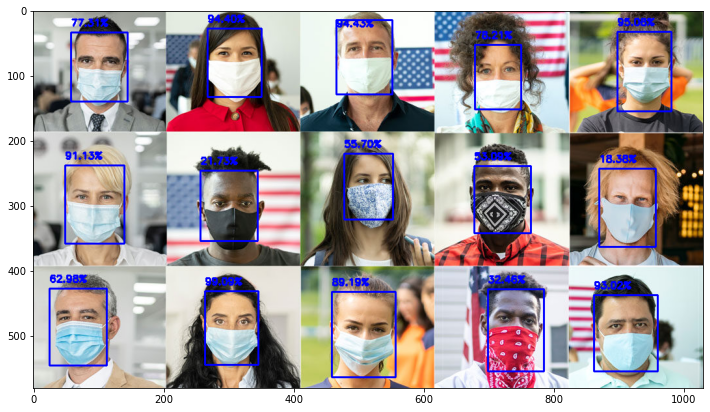

In [613]:
path = '../input/mask-no-mask-images/faces3.jpg'
facesbb=Caffe_boxFaces(path, net)
plt.figure(figsize=(12,12))
plt.imshow(facesbb[0])

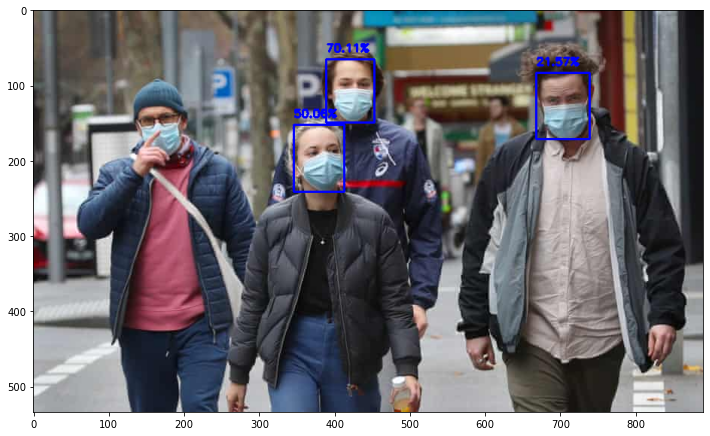

In [614]:
path = '../input/mask-no-mask-images/faces2.jpg'
facesbb=Caffe_boxFaces(path, net)
plt.figure(figsize=(12,12))
plt.imshow(facesbb[0])

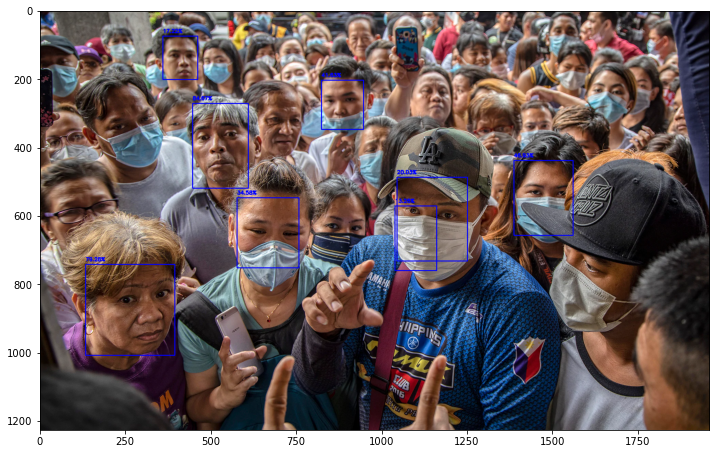

In [615]:
path = '../input/mask-no-mask-images/faces.jpg'
facesbb=Caffe_boxFaces(path, net)
plt.figure(figsize=(12,12))
plt.imshow(facesbb[0])

In [616]:
def Caffe_ResMaskNet(path):
    faces=Caffe_boxFaces(path, net)[1]

    image = cv2.imread(path)
    new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    for i in range(0, len(faces)):
        (x1,y1,x2,y2) = (faces[i][0],faces[i][1],faces[i][2],faces[i][3])
        crop = image[y1:y2,x1:x2]
        if crop.shape[0] > 0:
            try:
                crop = cv2.resize(crop,(150,150))
                crop = np.reshape(crop,[1,150,150,3])/255.0
                mask_result = model.predict(crop)
                cv2.putText(image,mask_label[mask_result.argmax()],(x1, y1),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[mask_result.argmax()],2)
                cv2.rectangle(image,(x1,y1),(x2,y2),dist_label[mask_result.argmax()],2)
            except:
                pass
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

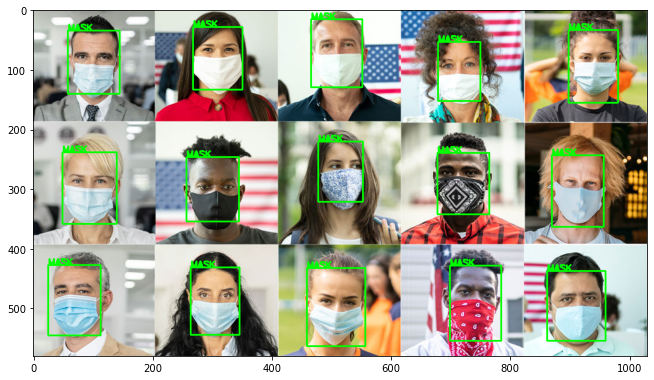

In [617]:
path = '../input/mask-no-mask-images/faces3.jpg'
plt.figure(figsize=(11,11))
plt.imshow(Caffe_ResMaskNet(path))

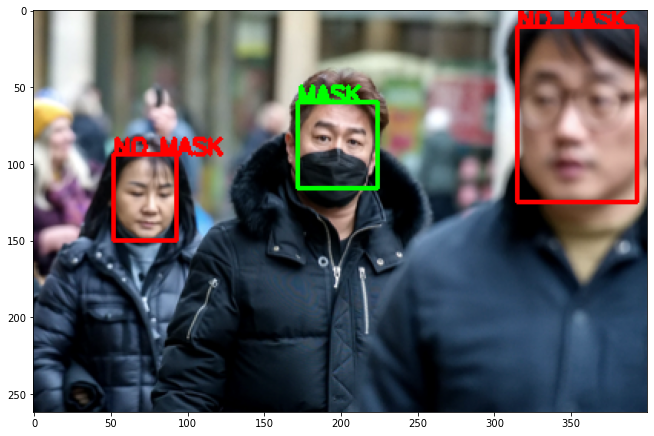

In [618]:
path = '../input/mask-no-mask-images/test_multiple.png'
plt.figure(figsize=(11,11))
plt.imshow(Caffe_ResMaskNet(path))

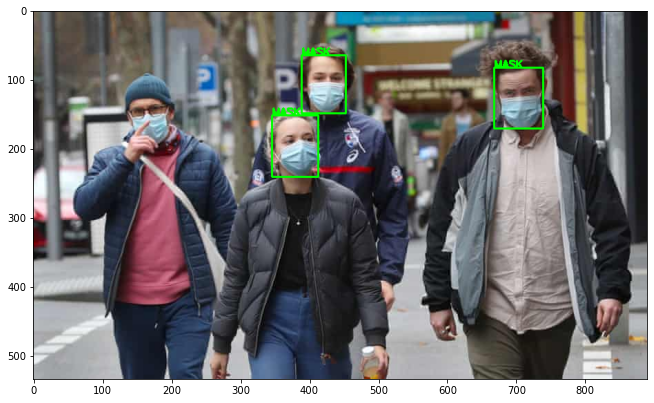

In [619]:
path = '../input/mask-no-mask-images/faces2.jpg'
plt.figure(figsize=(11,11))
plt.imshow(Caffe_ResMaskNet(path))

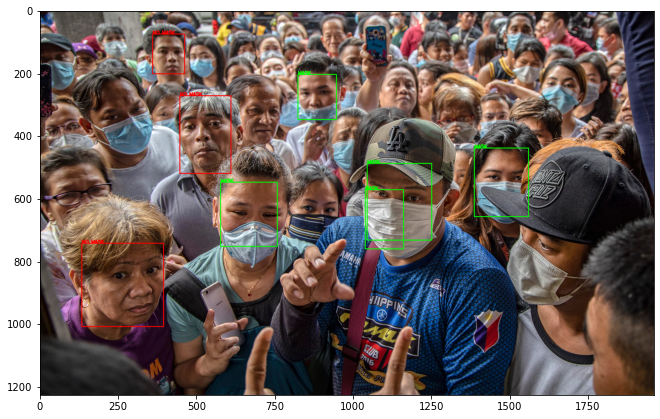

In [620]:
path = '../input/mask-no-mask-images/faces.jpg'
plt.figure(figsize=(11,11))
plt.imshow(Caffe_ResMaskNet(path))
